<a href="https://colab.research.google.com/github/BaRRdAk/rcnn/blob/main/gdal_raster.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Create Geotiff

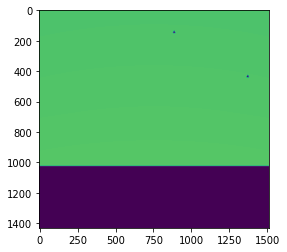

In [60]:
from osgeo import osr, gdal, ogr
import matplotlib.pyplot as plt
import numpy as np


ds = gdal.Open("map_ME2_79_7.tiff")
width = ds.RasterXSize
height = ds.RasterYSize
datas = ds.ReadAsArray(0,0,width,height)

datas_1 = []
for i in range(3):
  band = ds.GetRasterBand(i+1)
  data = band.ReadAsArray(0,0,width,height)
  datas_1.append(np.reshape(data,(1,-1)))
datas_1 = np.concatenate(datas_1)


geoTiffDriver = gdal.GetDriverByName("GTiff")

tods = geoTiffDriver.Create("test_2.tif", width, height, 3, options=["INTERLEAVE=PIXEL"])
tods.WriteRaster(0, 0, width, height, datas_1.tobytes(), width, height, band_list=[1,2,3])

tods.FlushCache()

# show result
res = gdal.Open("test_2.tif")
band = res.GetRasterBand(1)
arr = band.ReadAsArray()

im = plt.imshow(arr)

# Spatial reference and writing of projection information

In [23]:
# GT(0) x-coordinate of the upper-left corner of the upper-left pixel.
# GT(1) w-e pixel resolution / pixel width.
# GT(2) row rotation (typically zero).
# GT(3) y-coordinate of the upper-left corner of the upper-left pixel.
# GT(4) column rotation (typically zero).
# GT(5) n-s pixel resolution / pixel height (negative value for a north-up image)

bottom_left = [4611314.9914456,6590402.9860494]
top_right = [4655320.4908912,6632051.0480247]
x_pixel_res = height/(top_right[0] - bottom_left[0])
y_pixel_res = width/(bottom_left[1] - top_right[1])

tods.SetGeoTransform([top_right[0], x_pixel_res, 0, bottom_left[1], 0, y_pixel_res])

srs = osr.SpatialReference()
#srs.ImportFromEPSG(4326)
srs.ImportFromProj4("+proj=merc +a=6378137 +b=6378137 +lat_ts=0.0 +lon_0=0.0 +x_0=0.0 +y_0=0 +k=1.0 +units=m +nadgrids=@null +wktext +no_defs")
tods.SetProjection( srs.ExportToWkt() )

0

# Polyginize

In [ ]:
dst_layername = "POLYGONIZED_STUFF"
shapeDriver = ogr.GetDriverByName("ESRI Shapefile")
dst_ds = shapeDriver.CreateDataSource(dst_layername + ".shp")

dst_layer = dst_ds.CreateLayer(dst_layername, srs=None)
gdal.Polygonize(band, None, dst_layer, -1, [], callback=None)

# Simplify geometry

In [ ]:
feat = dst_layer.GetFeature(0)
geom = feat.geometry()
simple = geom.Simplify(0.2)

target_ds = geoTiffDriver.Create("rasterize.tif", 500, 500, gdal.GDT_Byte)

gdal.RasterizeLayer(target_ds, [3,2,1], dst_layer, burn_values=[200,220,240])
